In [1]:
from torch.distributed.algorithms.ddp_comm_hooks.ddp_zero_hook import hook_with_zero_step
!pip install pandas-datareader

In [2]:
import pandas as pd
import pandas_ta as ta
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
from IPython.extensions.autoreload import append_obj
from networkx import fast_gnp_random_graph
from sklearn.preprocessing import StandardScaler
from datetime import date, datetime
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [19]:
#Dwonloading historical data for Apple Inc. (AAPL), Microsoft Corp. (MSFT), and Google LLC (GOOGL) to files
tickers = ['AAPL', 'GOOGL', 'MSFT']
for share in tickers:
    share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
    if isinstance(share_data.columns, pd.MultiIndex):
        share_data.columns = share_data.columns.get_level_values(0)
    share_data.reset_index(inplace=True)    
    share_data.rename(columns={'Date':'DATE'}, inplace=True)
    share_data.to_csv(f'prices/historical_{share}_data.csv', index=False)
    
print(share_data.head(10))

/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_5233/1046079112.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_5233/1046079112.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_5233/1046079112.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed

Price       DATE      Close       High        Low       Open    Volume
0     2000-01-03  35.601448  36.231393  34.207933  35.849608  53228400
1     2000-01-04  34.398827  35.773253  34.284291  34.685165  54119000
2     2000-01-05  34.761509  35.544168  33.406173  33.940672  64059600
3     2000-01-06  33.597080  34.780614  33.100760  34.265204  54976600
4     2000-01-07  34.036144  34.284305  32.776253  33.177128  62013600
5     2000-01-10  34.284306  34.723358  34.017056  34.647001  44963600
6     2000-01-11  33.406189  34.895151  33.196207  34.055223  46743600
7     2000-01-12  32.318085  33.253458  31.898121  33.138922  66532400
8     2000-01-13  32.928955  33.177115  31.000941  31.879046  83144000
9     2000-01-14  34.284306  34.799716  32.299023  32.738076  73416400


In [4]:
MSFT_data = yf.download('MSFT', start='2000-01-01')

if isinstance(MSFT_data.columns, pd.MultiIndex):
    MSFT_data.columns = MSFT_data.columns.get_level_values(0)
    
### RSI
MSFT_data.ta.rsi(length=14, append=True)

### MACD
MSFT_data.ta.macd(fast=12, slow=26, signal=9, append=True)

### Bollinger Bands
MSFT_data.ta.bbands(length=20,std=2, append=True)

MSFT_data['Target'] = (MSFT_data['Close'].shift(-1) > MSFT_data['Close']).astype(int)

MSFT_data.dropna(inplace=True)

MSFT_data.reset_index(inplace=True)
MSFT_data.rename(columns={'Date':'DATE'}, inplace=True)
print(MSFT_data.head())


/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_5233/767811240.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  MSFT_data = yf.download('MSFT', start='2000-01-01')
[*********************100%***********************]  1 of 1 completed


Price       DATE      Close       High        Low       Open    Volume  \
0     2000-02-18  29.034748  30.561888  28.977480  30.542799  79063000   
1     2000-02-22  28.652954  29.664684  28.347526  29.053828  66296200   
2     2000-02-23  28.786585  29.244727  28.118461  28.557514  75847200   
3     2000-02-24  28.939301  29.282907  28.099374  28.786587  69733200   
4     2000-02-25  27.889395  28.924987  27.641235  28.920214  65301400   

Price     RSI_14  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  BBL_20_2.0_2.0  \
0      31.629571     -0.866585      -0.218360      -0.648225       28.692143   
1      30.545672     -0.966703      -0.254783      -0.711921       28.351638   
2      31.431364     -1.023467      -0.249237      -0.774230       28.069194   
3      32.490881     -1.044095      -0.215892      -0.828203       27.882795   
4      29.155440     -1.132110      -0.243126      -0.888984       27.508575   

Price  BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  BBP_20_2.0_2.0  Tar

        DATE  FEDFUNDS
0 2000-01-01      5.45
1 2000-02-01      5.73
2 2000-03-01      5.85
3 2000-04-01      6.02
4 2000-05-01      6.27


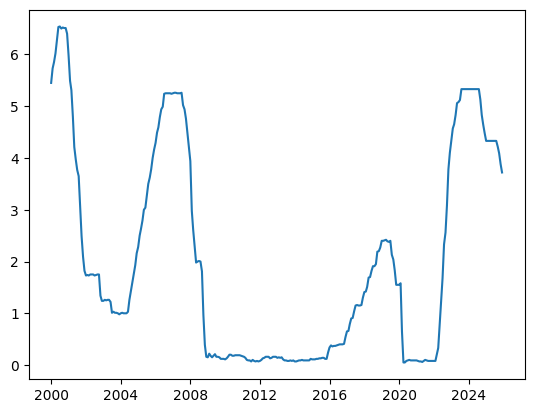

In [5]:
## Loading macro economic data
### need to install pandas-datareader 

### Fed Funds Rate (pol: Stopy procentowe)

FEDFUNDS = web.DataReader('FEDFUNDS', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
FEDFUNDS.reset_index(inplace=True)

print(FEDFUNDS.head())
plt.plot(FEDFUNDS['DATE'], FEDFUNDS['FEDFUNDS'])
                               

        DATE  DGS10
0 2000-01-03   6.58
1 2000-01-04   6.49
2 2000-01-05   6.62
3 2000-01-06   6.57
4 2000-01-07   6.52


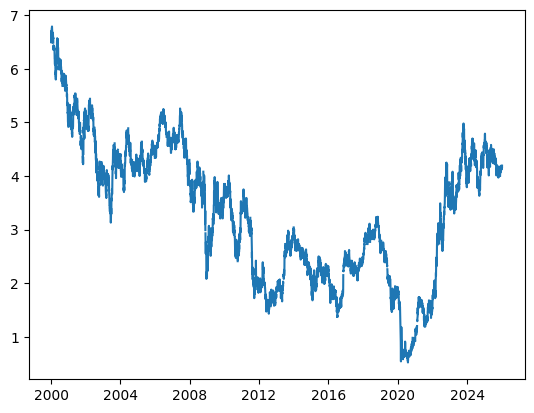

In [6]:
### Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (pol: Rentowność Obligacji 10-letnich)

DGS10 = web.DataReader('DGS10', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
DGS10.reset_index(inplace=True)
print(DGS10.head())
plt.plot(DGS10['DATE'], DGS10['DGS10'])

        DATE    CPI
0 2000-01-01  169.3
1 2000-02-01  170.0
2 2000-03-01  171.0
3 2000-04-01  170.9
4 2000-05-01  171.2
5 2000-06-01  172.2
6 2000-07-01  172.7
7 2000-08-01  172.7
8 2000-09-01  173.6
9 2000-10-01  173.9


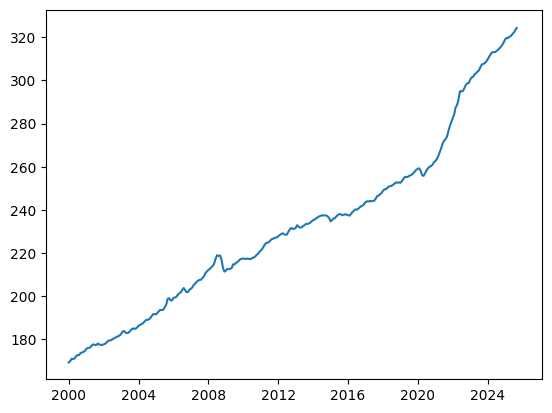

In [7]:
### CPI (pol: Wskaznik inflacji)

CPI = web.DataReader("CPIAUCSL", 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
CPI.reset_index(inplace=True)
CPI.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
print(CPI.head(10))
plt.plot(CPI['DATE'], CPI['CPI'])

        DATE  Dollar_idx
0 2006-01-02    101.4155
1 2006-01-03    100.7558
2 2006-01-04    100.2288
3 2006-01-05    100.2992
4 2006-01-06    100.0241
5 2006-01-09    100.1794
6 2006-01-10    100.1436
7 2006-01-11     99.8710
8 2006-01-12    100.0643
9 2006-01-13     99.9675


Text(0.5, 1.0, 'Dollar Index')

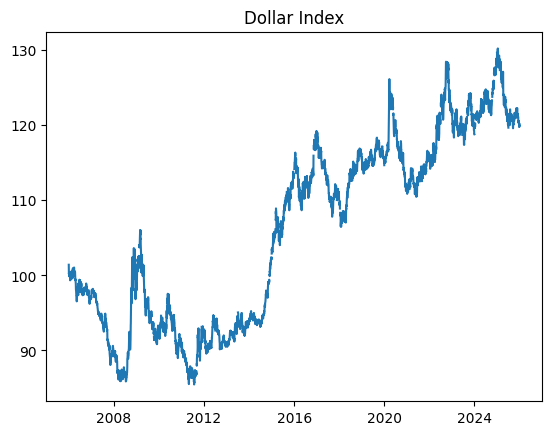

In [8]:
### Dollar index 

Dollar_idx = web.DataReader('DTWEXBGS', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
Dollar_idx.reset_index(inplace=True)
Dollar_idx.rename(columns={'DTWEXBGS': 'Dollar_idx'}, inplace=True)
print(Dollar_idx.head(10))
plt.plot(Dollar_idx['DATE'], Dollar_idx['Dollar_idx'])
plt.title('Dollar Index')


        DATE  FEDFUNDS  FEDFUNDS_scaled
0 2000-01-01      5.45         1.696853
1 2000-02-01      5.73         1.834880
2 2000-03-01      5.85         1.894035
3 2000-04-01      6.02         1.977837
4 2000-05-01      6.27         2.101076
        DATE  DGS10  DGS10_scaled
0 2000-01-03   6.58      2.514932
1 2000-01-04   6.49      2.445445
2 2000-01-05   6.62      2.545815
3 2000-01-06   6.57      2.507211
4 2000-01-07   6.52      2.468608
        DATE    CPI  CPI_scaled
0 2000-01-01  169.3   -1.556884
1 2000-02-01  170.0   -1.539742
2 2000-03-01  171.0   -1.515253
3 2000-04-01  170.9   -1.517702
4 2000-05-01  171.2   -1.510355
        DATE  Dollar_idx  Dollar_idx_scaled
0 2006-01-02    101.4155          -0.373495
1 2006-01-03    100.7558          -0.426799
2 2006-01-04    100.2288          -0.469382
3 2006-01-05    100.2992          -0.463693
4 2006-01-06    100.0241          -0.485922


Text(0.5, 1.0, 'All Macroeconomic datasets plots')

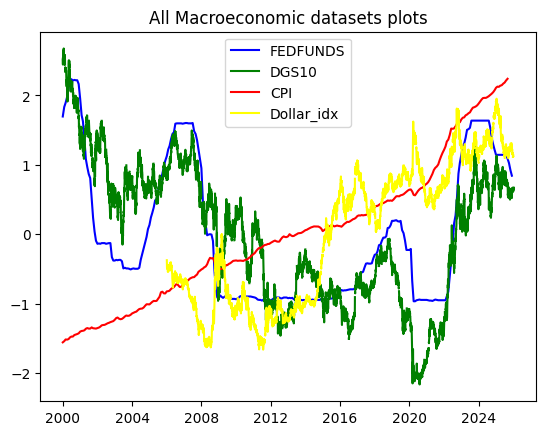

In [9]:
### Setting the same data time for all data

macroeconomic_datasets = [FEDFUNDS, DGS10, CPI, Dollar_idx]
labels = ['FEDFUNDS', 'DGS10', 'CPI', 'Dollar_idx']
plot_colors = ['blue', 'green', 'red', 'yellow', 'black']
scaler = StandardScaler()


for idx, dataset in enumerate(macroeconomic_datasets):
    dataset.sort_values('DATE', inplace=True)
    dataset.reset_index(drop=True, inplace=True)
    dataset[labels[idx] + "_scaled"] = scaler.fit_transform(dataset[[labels[idx]]])
    print(dataset.head(5))
    plt.plot(dataset['DATE'], dataset[labels[idx] + '_scaled'], color=plot_colors[idx])
plt.legend(labels)
plt.title('All Macroeconomic datasets plots')
    


In [10]:
## FEAR INDEX


### VIX < 20 -> Relative calm on the stock market
### VIX 20 -30 -> Increased volatility, uncertainty.
### VIX > 30 -> Panic on the stock market 


start_date = datetime(year=2000, month=1, day=1)
end_date = date.today().strftime('%Y-%m-%d')
fear_idx = yf.download(tickers= '^VIX',
                   start=start_date,
                   end=end_date,
                   auto_adjust=True,
                   progress=False,
                   interval="1d")
fear_idx.columns = [col[0] for col in fear_idx.columns]
fear_idx = pd.DataFrame(fear_idx)
fear_idx['VIX_percent'] = fear_idx['Close'].pct_change()
fear_idx.dropna(inplace=True)
fear_idx['Is_Panic'] = (fear_idx['Close'] > 30).astype(int)
fear_idx['Is_Calm'] = (fear_idx['Close'] < 20).astype(int)
fear_idx['Is_Uncertain'] = ((fear_idx['Close'] >= 20) & (fear_idx['Close'] <= 30)).astype(int)

fear_idx.reset_index(inplace=True)
fear_idx.rename(columns={'Date':'DATE'}, inplace=True)
fear_idx.head()

,DATE,Close,High,Low,Open,Volume,VIX_percent,Is_Panic,Is_Calm,Is_Uncertain
0,2000-01-04,27.010000,27.180000,24.799999,24.940001,0,0.115655,0,0,1
1,2000-01-05,26.410000,29.000000,25.850000,27.980000,0,-0.022214,0,0,1
2,2000-01-06,25.730000,26.709999,24.700001,26.680000,0,-0.025748,0,0,1
3,2000-01-07,21.719999,25.170000,21.719999,25.139999,0,-0.155849,0,0,1
4,2000-01-10,21.709999,22.490000,21.360001,21.889999,0,-0.000460,0,0,1


In [11]:
!pip install --upgrade datasets

In [12]:
### FINANCIAL NEWS

financial_sentiment = web.DataReader('USEPUINDXD', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
financial_sentiment.reset_index(inplace=True)
print(financial_sentiment.head())

        DATE  USEPUINDXD
0 2000-01-01       68.04
1 2000-01-02      119.36
2 2000-01-03       35.73
3 2000-01-04      109.31
4 2000-01-05      123.22


In [13]:
GOOGL = pd.read_csv('prices/historical_GOOGL_data.csv')
AAPL = pd.read_csv('prices/historical_AAPL_data.csv')

columns = AAPL.columns
columns = columns[1:]

for c in columns:
    GOOGL.rename(columns={c: c+'_GOOGL'}, inplace=True)
    AAPL.rename(columns={c: c+'_AAPL'}, inplace=True)
        
print(GOOGL.head())
print(AAPL.head())



         DATE  Close_GOOGL  High_GOOGL  Low_GOOGL  Open_GOOGL  Volume_GOOGL
0  2004-08-19     2.492181    2.584576   2.383393    2.483736     893181924
1  2004-08-20     2.690134    2.709259   2.496155    2.508822     456686856
2  2004-08-23     2.717207    2.818544   2.708514    2.750738     365122512
3  2004-08-24     2.604693    2.771850   2.572405    2.762908     304946748
4  2004-08-25     2.632761    2.682435   2.580105    2.606930     183772044
         DATE  Close_AAPL  High_AAPL  Low_AAPL  Open_AAPL  Volume_AAPL
0  2000-01-03    0.839281   0.843498  0.762428   0.786328    535796800
1  2000-01-04    0.768521   0.829440  0.758680   0.811633    512377600
2  2000-01-05    0.779767   0.828971  0.772269   0.777892    778321600
3  2000-01-06    0.712287   0.802260  0.712287   0.795700    767972800
4  2000-01-07    0.746027   0.757274  0.716037   0.723534    460734400


In [14]:
### MERGE ALL DATASETS TOGETHER
datasets = [FEDFUNDS, DGS10, CPI, Dollar_idx, financial_sentiment, fear_idx, AAPL, GOOGL]

data = MSFT_data.copy()
for dataset in datasets:
    dataset['DATE'] = pd.to_datetime(dataset['DATE'])
    data = pd.merge(data, dataset, on='DATE', how='left')
    
    

print(data.head(10))

        DATE    Close_x     High_x      Low_x     Open_x   Volume_x  \
0 2000-02-18  29.034748  30.561888  28.977480  30.542799   79063000   
1 2000-02-22  28.652954  29.664684  28.347526  29.053828   66296200   
2 2000-02-23  28.786585  29.244727  28.118461  28.557514   75847200   
3 2000-02-24  28.939301  29.282907  28.099374  28.786587   69733200   
4 2000-02-25  27.889395  28.924987  27.641235  28.920214   65301400   
5 2000-02-28  27.965750  28.137553  26.915841  27.564876   76131800   
6 2000-02-29  27.297621  28.023012  27.144907  28.023012   58437400   
7 2000-03-01  27.736673  28.738859  27.163996  27.373978  106889800   
8 2000-03-02  28.519339  29.130195  27.832126  28.042107  106932600   
9 2000-03-03  29.359268  30.199195  28.672055  28.939305  101435200   

      RSI_14  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  ...  Close_AAPL  \
0  31.629571     -0.866585      -0.218360      -0.648225  ...    0.834126   
1  30.545672     -0.966703      -0.254783      -0.711921  ...   

In [18]:
### CLEANING DATA

data.dropna(inplace=True)
data.ffill(inplace=True)
data.rename(columns={'Volume_x': 'Volume_MSFT'}, inplace=True)

print(data.describe())

data.to_csv('all_data.csv', index=False)

                                DATE     Close_x      High_x       Low_x  \
count                            152  152.000000  152.000000  152.000000   
mean   2015-11-26 08:31:34.736841984  118.960351  120.228359  117.745851   
min              2006-02-01 00:00:00   13.589223   14.233813   13.366256   
25%              2011-01-16 12:00:00   21.333745   21.402472   21.052003   
50%              2016-02-15 12:00:00   46.652216   46.701029   45.961839   
75%              2020-12-16 12:00:00  218.682831  220.354748  216.439821   
max              2025-08-01 00:00:00  522.272339  533.921354  519.033734   
std                              NaN  132.703384  134.273370  131.379605   

           Open_x   Volume_MSFT      RSI_14  MACD_12_26_9  MACDh_12_26_9  \
count  152.000000  1.520000e+02  152.000000    152.000000     152.000000   
mean   118.956492  4.522218e+07   55.150512      0.893903       0.100275   
min     13.403016  1.494200e+07   21.555484     -6.733165      -3.632859   
25%     21.